In [1]:
import gw_detections_functions as gwfn
import quantum_matched_filter_functions as qmffn
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import scipy.signal
import numpy as np

In [2]:
ht = np.loadtxt('data/H-H1_GWOSC_4KHZ_R1-1126259447-32.txt', skiprows=3)
psd_data = np.loadtxt('data/GWTC1_GW150914_PSDs.dat', skiprows=1, usecols=[0,1])

In [3]:
fs = 4096
f_low = 20.
dt=1./fs
T = 32
df = 1./T
N = int(T*fs)
t = dt*np.arange(N)
f = df*np.arange(N//2 + 1)

In [4]:
T_new = 28
fs_new = 4096
dt_new = 1./fs_new
df_new = 1./T_new
N_new = int(T_new*fs)
t_new = dt*np.arange(N_new)
f_new = df_new*np.arange(N_new//2 + 1)

In [5]:
inv_psd_func = interp1d(psd_data[:,0],1.0/psd_data[:,1],kind='linear',fill_value=(0.0,0.0),bounds_error=False)
inv_psd = inv_psd_func(f)

In [6]:
ht_w = gwfn.whiten(ht,inv_psd,fs)

In [7]:
ht_wb = gwfn.highpass(ht_w,f_low,fs)

In [8]:
ht_wbc = ht_wb[fs*(T - T_new)//2:-fs*(T - T_new)//2]

In [9]:
inv_psd = inv_psd_func(f_new)

In [10]:
_, st_wbc = gwfn.make_template(33.4,33.4,fs_new,T_new,inv_psd)

In [11]:
snr = gwfn.get_snr(ht_wbc,st_wbc,fs_new)

In [12]:
print(np.max(snr))

18.19810882667231


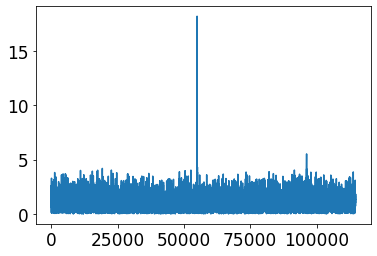

In [13]:
plt.plot(snr)

In [14]:
np.save('data/signal',ht_wbc)
np.save('data/psd', 1./inv_psd)

/home/fergus/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


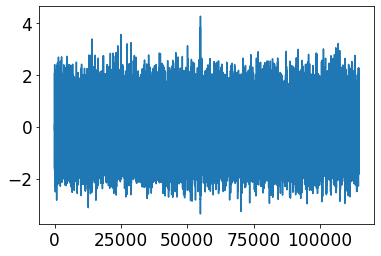

In [15]:
plt.plot(ht_wbc)

In [16]:
bank, _, _ = qmffn.get_paras(2**8)

In [17]:
m1s = bank['mass1']
m2s = bank['mass2']
s1s = bank['spin1z']
s2s = bank['spin2z']
fls = bank['f_lower']
paras = iter(np.array([m1s,m2s,s1s,s2s,fls]).T)

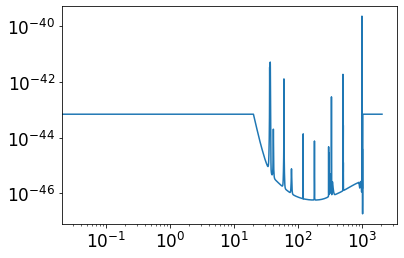

In [18]:
psd_func = interp1d(psd_data[:,0],psd_data[:,1],kind='linear',fill_value=(psd_data[0,1],psd_data[0,1]),bounds_error=False)
psd = psd_func(f_new)
plt.loglog(f_new,psd)

In [ ]:
noise_ = pycbc.noise.noise_from_psd(len(strain), strain.delta_t, psd_noise)